In [1]:
from osgeo import gdal
import sklearn as sk
import dice
import input_test_inter
import numpy as np
import tensorflow as tf
import time
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg


In [3]:
# ./modelos_clases_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_100.ckpt
batch_size = 39279/100
dropout = 0.5
n_classes = 4
epsilon=1e-08
epochs=11
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.96
bands=7
epsilon=1e-08
learning_rate = 0.00001

In [4]:
dataset= input_test_inter.read_data_sets('/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_20x20_Clases_4',
                                   '/media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_validation/20x20_Clases_4',
                                   bands,n_clases=n_classes)
# /media/gitecx/Nuevo vol/ASIAlac/Dataset/Dataset_11x11

39279
4364
76634


In [5]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [6]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
def continue_training (model_path,size, size_text, ep):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        
        for i in range (1,int(size/batch_size)*int(epochs)):
            
            batch_xs, batch_ys ,_= dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(size/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0
                y_p = tf.argmax(pred,1)
                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = size_text/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys,_ = dataset.test.next_batch(batch_size)
                    predictions = sess.run([correct_pred], feed_dict={x: t_batch_xs,
                                                                      y: t_batch_ys, keep_prob: 1.})
                    prediction  = tf.argmax(pred,1)
                    y_true = np.argmax(t_batch_ys,1)
                    print t_batch_ys.dtype
                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
                                                        keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

        
                a=confusion_matrix(y_true_a, y_pred_a)            
                
                accuaracy,matrix=precision_measure(a)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a)
        print (matrix)
        model= "./modelos_20x20_4/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(batch_size)+"_ep_"+str(ep)+".ckpt"
        save_path = saver.save(sess, model)
        print ("model saved")
        print (model)
        sess.close()

In [8]:
def precision_measure (a2):
    pro=0
    b2=a2.astype(float)

    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    for l in range (n_classes):
        if(b2[l][l]!=np.nan):
            pro+=b2[l][l]
        
    pro=pro/n_classes 
    return pro,b2

In [9]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return matrix

In [10]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        y_p = tf.argmax(pred,1)
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
        posicion=[]
######################################################
###   Test 
######################################################
        while step < limit:
            t_batch_xs, t_batch_ys,p = dataset.validation.next_batch(batch_size)
            prediction  = tf.argmax(pred,1)
            y_true = np.argmax(t_batch_ys,1)
            pred_1 = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=pred_1              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, pred_1))
            step+=1
            
            for i in range(len(p)):
                xi=p[i].find('x=')
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],pred_1[i]])
           
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        print (a)
                       
        accuaracy,matrix=precision_measure(a)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)        
        print (matrix)
        sess.close()
    return matrix,posicion

In [11]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
# 39279
# 4364
# 43643

##########################################################            
###   TRAIN
##########################################################
    
    # Keep training until reach max iterations
    for i in range (1,int(39279/batch_size)*int(epochs)): 
        
        batch_xs, batch_ys = dataset.train.next_batch(batch_size)
        # Fit training using batch data

        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(39279/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 4364/100
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys = dataset.test.next_batch(batch_size)
                prediction  = tf.argmax(pred,1)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a=confusion_matrix(y_true_a, y_pred_a)            
            accuaracy,matrix=precision_measure(a)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################
#           %matplotlib
#           import matplotlib.pyplot as plt
#           l=np.arange(0.0, epochs-1, 1.)
#           plt.plot(val,l, 'r--') 
    print "Optimization Finished!"    
    model= "./modelos_20x20_4/model_" + "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_Bathsize_"+str(batch_size)+".ckpt"
    np.set_printoptions(precision=3, suppress=True)
    print (a)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    sess.close()        
        

Start Train
time this epoch= 0.096027
test accuracy 0.378085270872
time this epoch= 0.096409
test accuracy 0.406611257508
time this epoch= 0.095793
test accuracy 0.450961107113
time this epoch= 0.097651
test accuracy 0.50655973488
time this epoch= 0.093626
test accuracy 0.56988653331
time this epoch= 0.094276
test accuracy 0.622638955753
time this epoch= 0.094213
test accuracy 0.657260896652
time this epoch= 0.097523
test accuracy 0.670973136382
time this epoch= 0.097714
test accuracy 0.68943557905
time this epoch= 0.095489
test accuracy 0.700785053565
Optimization Finished!
[[4102    6   12   94]
 [ 165  270 1372 2412]
 [ 146   89 3405  567]
 [ 139   34   11 4032]]
[[ 0.973  0.001  0.003  0.022]
 [ 0.039  0.064  0.325  0.572]
 [ 0.035  0.021  0.809  0.135]
 [ 0.033  0.008  0.003  0.956]]
Model saved in file: ./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_392.ckpt


# Prueba con los datos de entrenamiento las primeras 11 epocas

Model successfully restored
sklearn martix
test accuracy 0.707733150517
[[ 0.976  0.002  0.002  0.021]
 [ 0.038  0.072  0.351  0.539]
 [ 0.033  0.023  0.825  0.118]
 [ 0.034  0.005  0.003  0.958]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


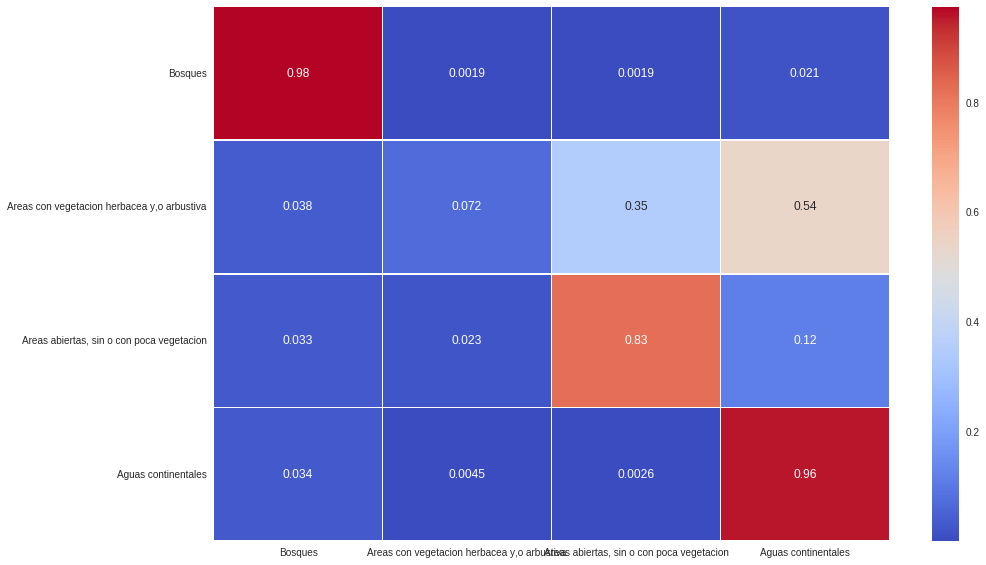

In [12]:

matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_392.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion Primeras 11 epocas

Model successfully restored
sklearn martix
[[167405    126    244   1847]
 [   642   3060  43108  71560]
 [     8      4     75      7]
 [   430      4      8  11352]]
test accuracy 0.693294140888
[[ 0.987  0.001  0.001  0.011]
 [ 0.005  0.026  0.364  0.605]
 [ 0.085  0.043  0.798  0.074]
 [ 0.036  0.     0.001  0.963]]


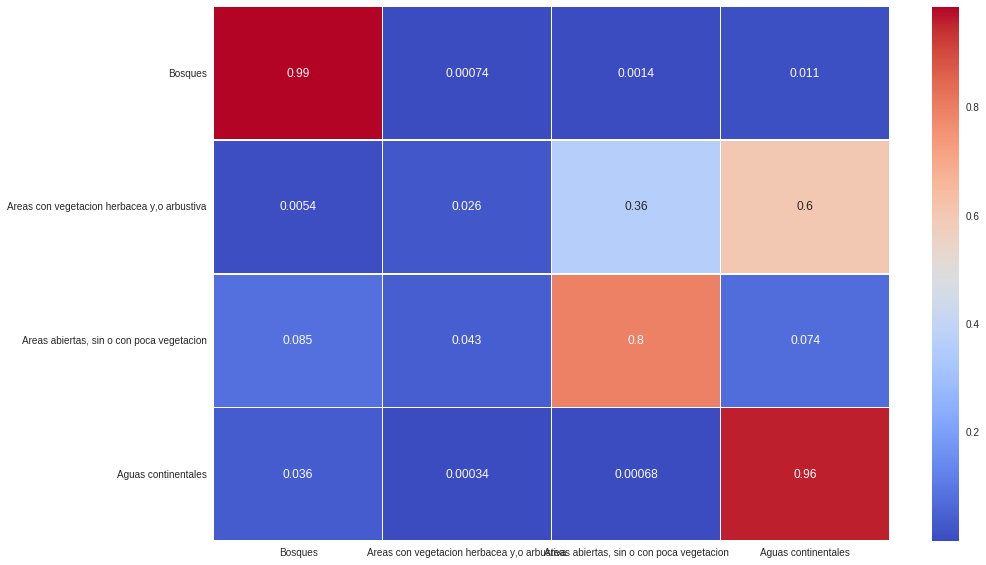

In [13]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_392.ckpt', 
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Restaurar modelos

## Redefinir variables

In [14]:
continue_training('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_392.ckpt',
                  39279,4364,21)


Model successfully restored
time this epoch= 0.098696
test accuracy 0.714463252345
time this epoch= 0.105488
test accuracy 0.727630254631
time this epoch= 0.097381
test accuracy 0.734950248845
time this epoch= 0.096235
test accuracy 0.750834926633
time this epoch= 0.104981
test accuracy 0.762709342496
time this epoch= 0.097951
test accuracy 0.776273049048
time this epoch= 0.095642
test accuracy 0.787872821803
time this epoch= 0.0988910000001
test accuracy 0.799449456104
time this epoch= 0.09657
test accuracy 0.80642612426
time this epoch= 0.090752
test accuracy 0.818560184656
[[1053    1    1   19]
 [  46  503  304  225]
 [  34   30  941   79]
 [  42    1    1 1032]]
[[ 0.98   0.001  0.001  0.018]
 [ 0.043  0.467  0.282  0.209]
 [ 0.031  0.028  0.868  0.073]
 [ 0.039  0.001  0.001  0.959]]
model saved
./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_21.ckpt


# # Prueba con los datos de entrenamiento epoca 21

In [11]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_21.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# 39279
# 4364
# 76634

Model successfully restored
sklearn martix
test accuracy 0.8359573961
[[ 0.98   0.     0.002  0.018]
 [ 0.042  0.522  0.267  0.169]
 [ 0.02   0.03   0.888  0.062]
 [ 0.043  0.001  0.003  0.953]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Validacion en la epoca 21

In [16]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_21.ckpt', size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

Model successfully restored
sklearn martix
[[167729    193    282   1423]
 [   649  31977  50953  34735]
 [     8      4     79      5]
 [   514      0      4  11325]]
test accuracy 0.75956520473
[[ 0.989  0.001  0.002  0.008]
 [ 0.005  0.27   0.431  0.294]
 [ 0.083  0.042  0.823  0.052]
 [ 0.043  0.     0.     0.956]]


In [17]:
continue_training('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_21.ckpt',
                  39279,4364,32)

Model successfully restored
time this epoch= 0.0965229999999
test accuracy 0.840406747399
time this epoch= 0.095206
test accuracy 0.850044239144
time this epoch= 0.097694
test accuracy 0.852213029887
time this epoch= 0.097154
test accuracy 0.862370559465
time this epoch= 0.097777
test accuracy 0.868275042259
time this epoch= 0.096749
test accuracy 0.870687922483
time this epoch= 0.0939129999999
test accuracy 0.871282405426
time this epoch= 0.0981320000001
test accuracy 0.877202817022
time this epoch= 0.0940069999999
test accuracy 0.880452492648
time this epoch= 0.097708
test accuracy 0.880825468864
[[1069    1    1   16]
 [  43  807  185   67]
 [  32   85  906   45]
 [  37    5    1 1012]]
[[ 0.983  0.001  0.001  0.015]
 [ 0.039  0.732  0.168  0.061]
 [ 0.03   0.08   0.848  0.042]
 [ 0.035  0.005  0.001  0.959]]
model saved
./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_32.ckpt


# Prueba en la epoca 33

Model successfully restored
sklearn martix
test accuracy 0.88878373684
[[ 0.983  0.002  0.002  0.013]
 [ 0.039  0.744  0.166  0.051]
 [ 0.02   0.07   0.879  0.031]
 [ 0.043  0.005  0.003  0.949]]


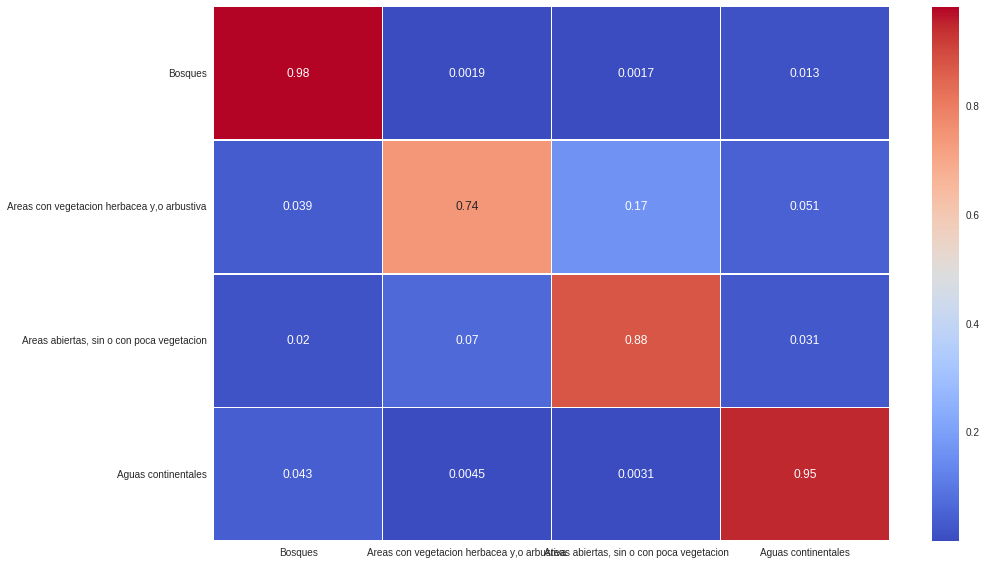

In [12]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_32.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion en la epoca 33

In [20]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_32.ckpt',
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

Model successfully restored
sklearn martix
[[167755    458    269   1090]
 [   640  61149  43229  13400]
 [    10      7     75      0]
 [   530      0      4  11264]]
test accuracy 0.818905728655
[[ 0.989  0.003  0.002  0.006]
 [ 0.005  0.516  0.365  0.113]
 [ 0.109  0.076  0.815  0.   ]
 [ 0.045  0.     0.     0.955]]


In [11]:
continue_training('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_392_ep_32.ckpt',
                  39279,4364,44)

Model successfully restored
time this epoch= 0.099045
test accuracy 0.894881692222
time this epoch= 0.097873
test accuracy 0.896137778175
time this epoch= 0.096242
test accuracy 0.89641655373
time this epoch= 0.094855
test accuracy 0.898368012236
time this epoch= 0.097434
test accuracy 0.896627951304
time this epoch= 0.095894
test accuracy 0.897853962071
time this epoch= 0.096345
test accuracy 0.898751218919
time this epoch= 0.101633
test accuracy 0.901365033251
time this epoch= 0.095923
test accuracy 0.901835546798
time this epoch= 0.092214
test accuracy 0.90303791783
[[1054    1    3   19]
 [  38  871  128   39]
 [  16   93  944   27]
 [  38   15    1 1025]]
[[ 0.979  0.001  0.003  0.018]
 [ 0.035  0.809  0.119  0.036]
 [ 0.015  0.086  0.874  0.025]
 [ 0.035  0.014  0.001  0.95 ]]
model saved
./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_44.ckpt


# Prueba con los datos de entrenamiento epoca 44

Model successfully restored
sklearn martix
test accuracy 0.900664971876
[[ 0.984  0.002  0.001  0.013]
 [ 0.038  0.799  0.127  0.036]
 [ 0.019  0.094  0.868  0.019]
 [ 0.038  0.008  0.002  0.952]]


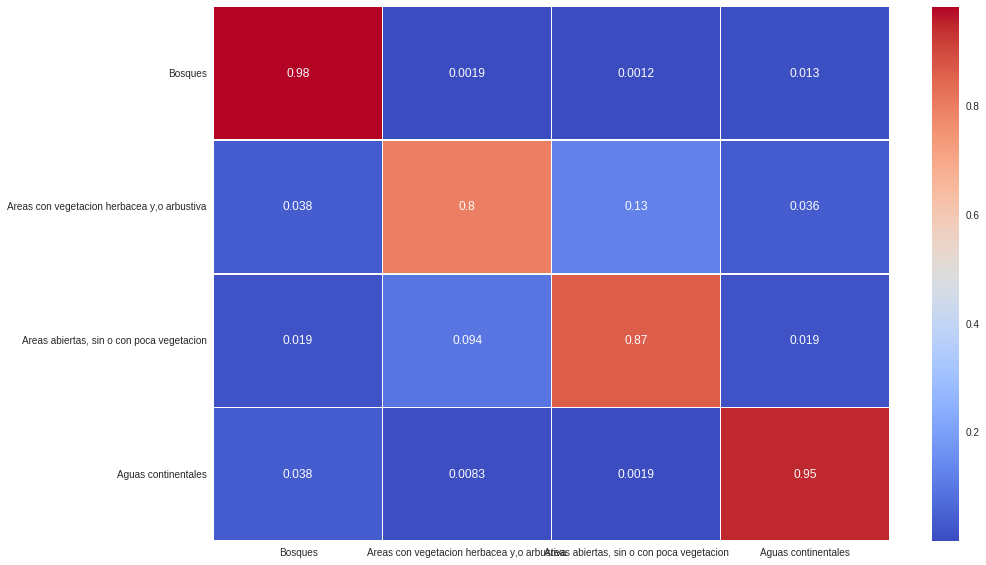

In [15]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_44.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion en la epoca 44

Model successfully restored
sklearn martix
[[167923    592    251    910]
 [   649  68282  40261   9095]
 [    11      8     76      0]
 [   502      0      4  11316]]
test accuracy 0.831030999707
[[ 0.99   0.003  0.001  0.005]
 [ 0.005  0.577  0.34   0.077]
 [ 0.116  0.084  0.8    0.   ]
 [ 0.042  0.     0.     0.957]]


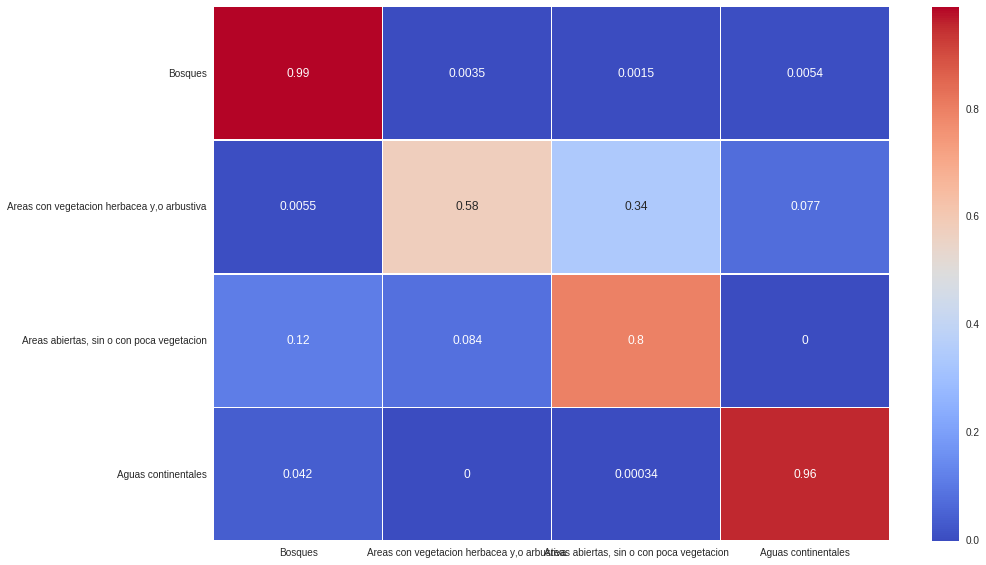

In [16]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_44.ckpt',
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [12]:
continue_training('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_44.ckpt',
                  39279,4364,55)

Model successfully restored
time this epoch= 0.097113
test accuracy 0.90453458329
time this epoch= 0.099589
test accuracy 0.905162477691
time this epoch= 0.093459
test accuracy 0.905696816736
time this epoch= 0.094363
test accuracy 0.908030507718
time this epoch= 0.095194
test accuracy 0.906843522685
time this epoch= 0.093596
test accuracy 0.906355785746
time this epoch= 0.0959580000001
test accuracy 0.906768707571
time this epoch= 0.092831
test accuracy 0.907339176078
time this epoch= 0.094257
test accuracy 0.907593427558
time this epoch= 0.095643
test accuracy 0.909436416351
[[1057    1    3   19]
 [  38  905  105   32]
 [  14  107  928   21]
 [  33   16    1 1032]]
[[ 0.979  0.001  0.003  0.018]
 [ 0.035  0.838  0.097  0.03 ]
 [ 0.013  0.1    0.867  0.02 ]
 [ 0.03   0.015  0.001  0.954]]
model saved
./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_55.ckpt


# Prueba con los datos de entrenamiento epoca 55

In [20]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_55.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

Model successfully restored
sklearn martix
test accuracy 0.906968509897
[[ 0.982  0.002  0.002  0.014]
 [ 0.036  0.818  0.118  0.027]
 [ 0.015  0.102  0.87   0.013]
 [ 0.032  0.009  0.002  0.958]]


# Validacion en la epoca 55

Model successfully restored
sklearn martix
[[167878    647    252    864]
 [   640  69861  40020   7894]
 [    13      6     71      0]
 [   487      3      3  11241]]
test accuracy 0.831612295759
[[ 0.99   0.004  0.001  0.005]
 [ 0.005  0.59   0.338  0.067]
 [ 0.144  0.067  0.789  0.   ]
 [ 0.042  0.     0.     0.958]]


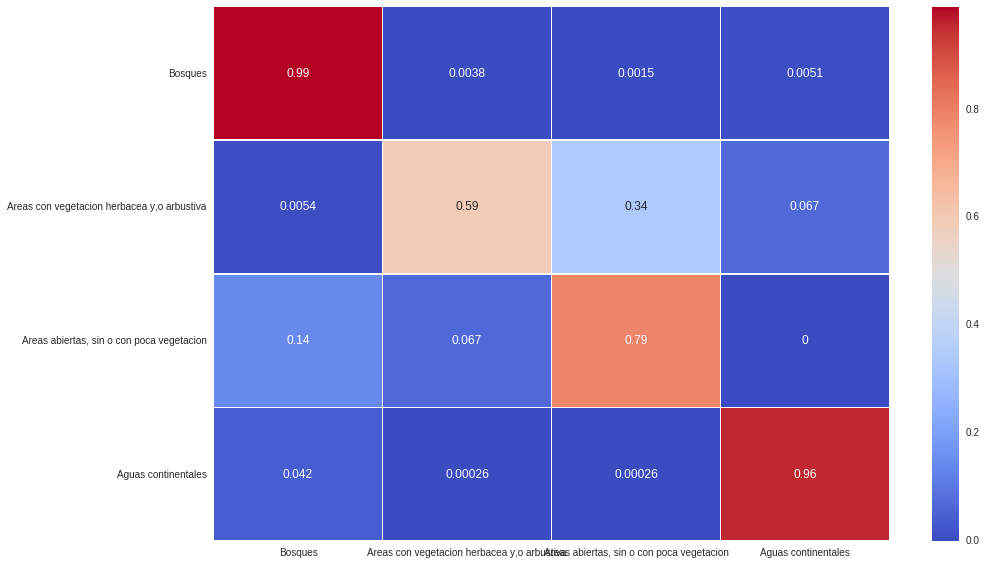

In [19]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_55.ckpt',
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [13]:
continue_training('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_55.ckpt',
                  39279,4364,66)

Model successfully restored
time this epoch= 0.096195
test accuracy 0.909870779042
time this epoch= 0.103426
test accuracy 0.910529172278
time this epoch= 0.097501
test accuracy 0.910624104445
time this epoch= 0.096362
test accuracy 0.910842343204
time this epoch= 0.09348
test accuracy 0.911950614463
time this epoch= 0.096097
test accuracy 0.912558034594
time this epoch= 0.096356
test accuracy 0.91232735281
time this epoch= 0.0924240000001
test accuracy 0.91326302511
time this epoch= 0.102798
test accuracy 0.91236094304
time this epoch= 0.097476
test accuracy 0.913848594678
[[1057    2    3   20]
 [  35  931   88   24]
 [  16  127  919   12]
 [  28   15    1 1034]]
[[ 0.977  0.002  0.003  0.018]
 [ 0.032  0.864  0.082  0.022]
 [ 0.015  0.118  0.856  0.011]
 [ 0.026  0.014  0.001  0.959]]
model saved
./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt


# Prueba con los datos de entrenamiento epoca 66

Model successfully restored
sklearn martix
test accuracy 0.912584118638
[[ 0.98   0.002  0.003  0.015]
 [ 0.038  0.844  0.094  0.024]
 [ 0.013  0.116  0.865  0.006]
 [ 0.029  0.009  0.002  0.961]]


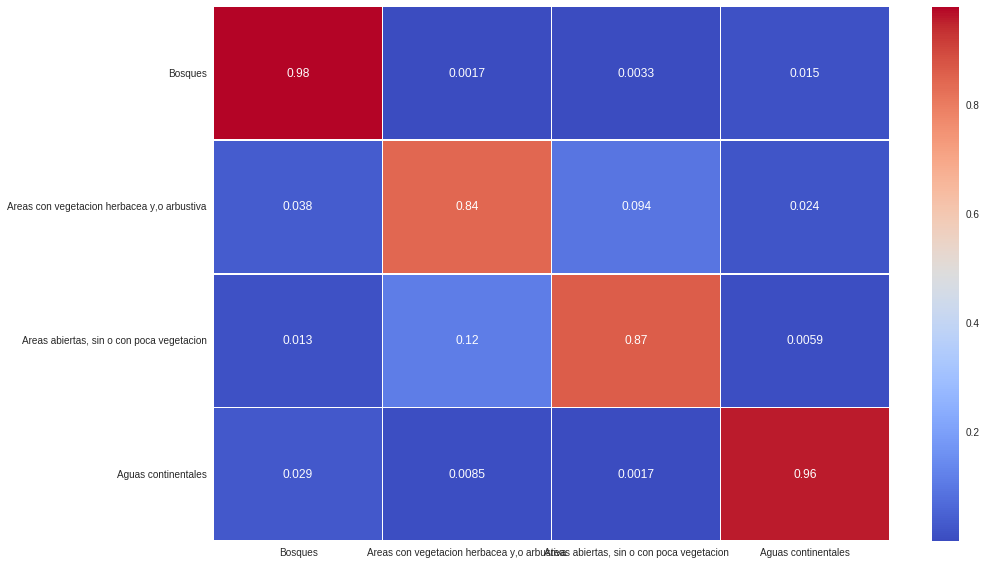

In [17]:
matrix=test_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',
                  4364)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

# Validacion en la epoca 66

Model successfully restored
sklearn martix
[[167821    691    265    757]
 [   627  71411  39487   6932]
 [    12     12     71      0]
 [   456      4      4  11330]]
test accuracy 0.825191360161
[[ 0.99   0.004  0.002  0.004]
 [ 0.005  0.603  0.333  0.059]
 [ 0.126  0.126  0.747  0.   ]
 [ 0.039  0.     0.     0.961]]


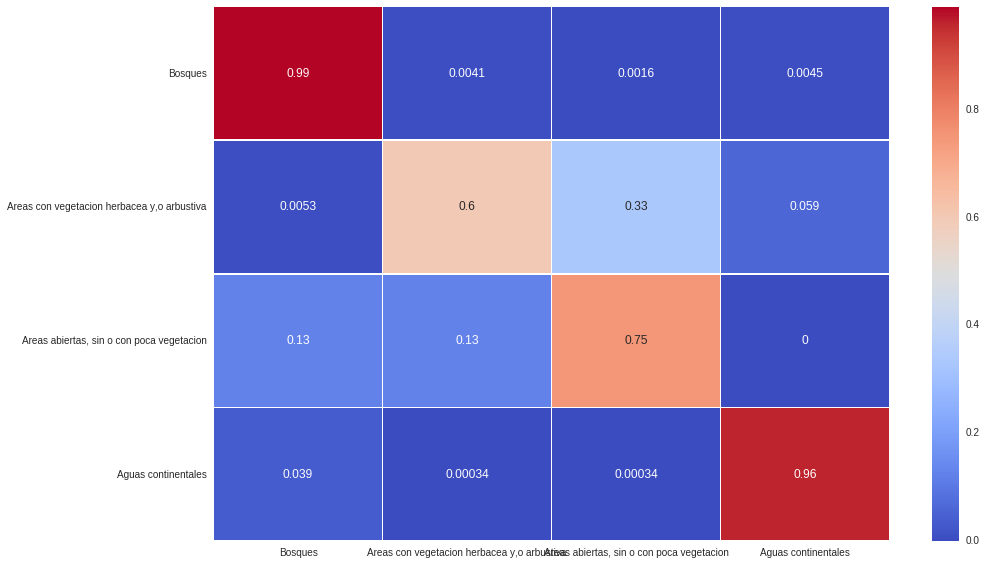

In [18]:
matrix=validation_model('./modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',
                        size =76634)
labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
f.tight_layout()

In [11]:
matrix,p=validation_model('/media/gitecx/Nuevo vol/ASIAlac/Modelos/modelos_20x20_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.96_epsilon_1e-08_bath_392_ep_66.ckpt',
                          size =76634)


Model successfully restored
sklearn martix
[[167874    688    258    751]
 [   635  71384  39458   6926]
 [    11     12     71      0]
 [   454      4      3  11351]]
test accuracy 0.827293390992
[[ 0.99   0.004  0.002  0.004]
 [ 0.005  0.603  0.333  0.058]
 [ 0.117  0.128  0.755  0.   ]
 [ 0.038  0.     0.     0.961]]


Coeficientes de Dice para la clase 1 0.878 clase 2 0.668 clase 0.008 clase 0.010
Mascaras Binarias por clase 
Predición de mapa al vuelo 


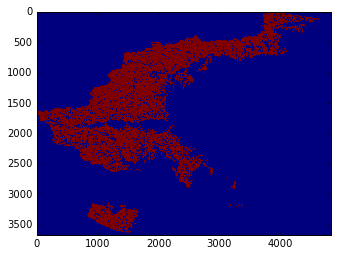

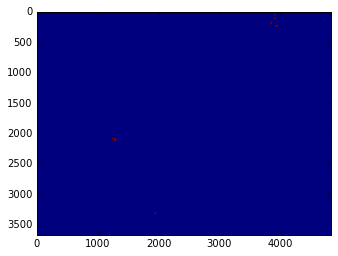

In [13]:
x_min = 851378.76
x_max = 996371.54

y_min = 788352.91
y_max = 898319.65
   
x_res = int((x_max - x_min) / 30)
y_res = int((y_max - y_min) / 30)
    
resolution=x_res*y_res

map_out = np.zeros(resolution).reshape(y_res,x_res)

a1=0
a2=0
for i in range (len(p)):
    xOffset = abs(int((float(p[i][0][0]) - x_min) / 30))
    yOffset = abs(int((float(p[i][1][0]) - y_max) / 30))

    k = p[i][2] + 1       
    y2=yOffset+20
    x2=xOffset+20
    if (x2<x_res):
        
        map_out[ yOffset:y2 , xOffset:x2 ] = k

c,mask =dice.coefficient(map_out,"/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/iMAGNEES DE SALIDA/s_out/Final Shape's/mask_validation.shp")
  
mask.append(map_out)
 
%matplotlib inline
print "Coeficientes de Dice para la clase 1 %.3f clase 2 %.3f clase %.3f clase %.3f" % (c[0], c[1], c[2], c[3])   
  
for i in range(5):
    if(i==4):
        print ("Predición de mapa al vuelo ")
    if (i==1):
        print "Mascaras Binarias por clase "
            
    plt.imshow(mask[i])
    plt.figure(i+1)
plt.show()